In [77]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [78]:
def obtener_nombres_archivos(directorio):
    nombres_archivos = []
    for nombre_archivo in os.listdir(directorio):
        ruta_archivo = os.path.join(directorio, nombre_archivo)
        if os.path.isfile(ruta_archivo):
            nombres_archivos.append(nombre_archivo)
    return nombres_archivos

directorio = './environmental_sensor_data'
lista_nombres_archivos = obtener_nombres_archivos(directorio)
print(lista_nombres_archivos)

['200034001951343334363036_air_temperature_raw.csv', '200034001951343334363036_atmospheric_pressure_raw.csv', '200034001951343334363036_battery_raw.csv', '200034001951343334363036_humidity_raw.csv', '200034001951343334363036_precipitation_raw.csv', '200034001951343334363036_soil_humidity_raw.csv', '200034001951343334363036_wind_direction_raw.csv', '200034001951343334363036_wind_speed_raw.csv', '270043001951343334363036_air_temperature_raw.csv', '270043001951343334363036_atmospheric_pressure_raw.csv', '270043001951343334363036_battery_raw.csv', '270043001951343334363036_humidity_raw.csv', '270043001951343334363036_precipitation_raw.csv', '270043001951343334363036_soil_humidity_raw.csv', '270043001951343334363036_wind_direction_raw.csv', '270043001951343334363036_wind_speed_raw.csv', '380033001951343334363036_air_temperature_raw.csv', '380033001951343334363036_atmospheric_pressure_raw.csv', '380033001951343334363036_battery_raw.csv', '380033001951343334363036_humidity_raw.csv', '38003300

In [79]:
def obtener_identificadores_y_tipos_archivos(lista_archivos):
    sensores = {}
    suffix = '_raw.csv'
    for archivo in lista_archivos:
        identificador = archivo.split("_")[0]
        tipo_archivo = archivo[len(identificador)+1:-len(suffix)]
        if(identificador not in sensores.keys()): 
            sensores[identificador] = {}
        sensores[identificador][tipo_archivo] = {"file": archivo}
    return sensores

sensores = obtener_identificadores_y_tipos_archivos(lista_nombres_archivos)
print(sensores)

{'200034001951343334363036': {'air_temperature': {'file': '200034001951343334363036_air_temperature_raw.csv'}, 'atmospheric_pressure': {'file': '200034001951343334363036_atmospheric_pressure_raw.csv'}, 'battery': {'file': '200034001951343334363036_battery_raw.csv'}, 'humidity': {'file': '200034001951343334363036_humidity_raw.csv'}, 'precipitation': {'file': '200034001951343334363036_precipitation_raw.csv'}, 'soil_humidity': {'file': '200034001951343334363036_soil_humidity_raw.csv'}, 'wind_direction': {'file': '200034001951343334363036_wind_direction_raw.csv'}, 'wind_speed': {'file': '200034001951343334363036_wind_speed_raw.csv'}}, '270043001951343334363036': {'air_temperature': {'file': '270043001951343334363036_air_temperature_raw.csv'}, 'atmospheric_pressure': {'file': '270043001951343334363036_atmospheric_pressure_raw.csv'}, 'battery': {'file': '270043001951343334363036_battery_raw.csv'}, 'humidity': {'file': '270043001951343334363036_humidity_raw.csv'}, 'precipitation': {'file': '2

In [80]:
len(sensores), len(lista_nombres_archivos)

(7, 56)

In [81]:
def cargar_datos(id, data):
    df = pd.read_csv(directorio + '/' + sensores[id][data]['file'])
    if data == 'wind_direction': 
        df.columns = ["timestamp", "_1", "_2", "wind_direction"]
        df = df.drop(['_1', '_2'], axis=1)
        df['wind_direction'].replace(to_replace=-1, value=np.NaN, inplace=True)
    else: 
        df.columns = ["timestamp", data]

    # Formatear timestamp 
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    # Ordenar
    df = df.sort_values(by=['timestamp'])
    # Agrupar valores en el mismo minuto
    df["timestamp"] = df["timestamp"].round('min')
    df = df.groupby(by='timestamp').first() 
    
    sensores[id][data]["df"] = df

    # Actualizar df_global
    if(sensores[id]['df_global'].empty):
        sensores[id]['df_global'] = df.copy()
    else:
        #sensores[id]['df_global'] = pd.merge_asof(sensores[id]['df_global'], df, on='timestamp', direction='nearest', tolerance=pd.Timedelta('5min'))
        sensores[id]['df_global'] = sensores[id]['df_global'].merge(df, on='timestamp', how='outer', sort=True)

In [82]:
for id in sensores.keys():
    sensores[id]['df_global'] = pd.DataFrame()

    cargar_datos(id, 'battery') # Target el primero
    cargar_datos(id, 'air_temperature')
    cargar_datos(id, 'atmospheric_pressure')
    cargar_datos(id, 'humidity')
    cargar_datos(id, 'precipitation')
    cargar_datos(id, 'soil_humidity')
    cargar_datos(id, 'wind_direction')
    cargar_datos(id, 'wind_speed')
    sensores[id]['df_global']['time_interval'] = sensores[id]['df_global'].index.diff()


In [83]:
stats_df = pd.DataFrame(columns=['Min','Max','Median','Mean','Count', 'NaNs', '%'])

# Loop over the sensors
for id in sensores.keys():
    
    # Add the number of data points in each time interval to the dataframe
    stats_df.loc[id] = [
        sensores[id]['df_global']['time_interval'].min(),
        sensores[id]['df_global']['time_interval'].max(),
        sensores[id]['df_global']['time_interval'].median(),
        sensores[id]['df_global']['time_interval'].mean(),
        len(sensores[id]['df_global']['time_interval']),
        (sensores[id]['df_global'].isnull() != 0).any(axis=1).sum(),
        (sensores[id]['df_global'].isnull() != 0).any(axis=1).sum() / len(sensores[id]['df_global'])*100       
    ]

stats_df

,Min,Max,Median,Mean,Count,NaNs,%
200034001951343334363036,0 days 00:01:00,0 days 09:50:00,0 days 00:10:00,0 days 00:10:13.424179193,23484,10764,45.835462
270043001951343334363036,0 days 00:01:00,37 days 07:56:00,0 days 00:10:00,0 days 00:14:32.327523777,20714,2561,12.363619
380033001951343334363036,0 days 00:01:00,6 days 21:54:00,0 days 00:10:00,0 days 00:11:27.502011263,19889,3326,16.722812
46004e000251353337353037,0 days 00:01:00,7 days 01:27:00,0 days 00:10:00,0 days 00:14:07.810044414,5855,1352,23.091375
46005a000351353337353037,0 days 00:01:00,0 days 01:27:00,0 days 00:10:00,0 days 00:09:46.430599632,5988,779,13.009352
4e0022000251353337353037,0 days 00:01:00,116 days 13:03:00,0 days 00:10:00,0 days 01:32:42.065888812,2915,787,26.998285
4e0031000251353337353037,0 days 00:01:00,4 days 03:50:00,0 days 00:10:00,0 days 00:10:23.434017988,22348,4248,19.008412


In [84]:
times_df = pd.DataFrame(columns=['<8min','>10min','>15min','>20min','>30min','>60min'])

# Loop over the sensors
for id in sensores.keys():
    # Get the time interval for the sensor

    ti = sensores[id]['df_global']['time_interval']
    
    # Add the number of data points in each time interval to the dataframe
    times_df.loc[id] = [
        (len(ti[(ti < pd.Timedelta('8min'))])),
        (len(ti[(ti > pd.Timedelta('10min')) & (ti <= pd.Timedelta('15min'))])),
        (len(ti[(ti > pd.Timedelta('15min')) & (ti <= pd.Timedelta('20min'))])),
        (len(ti[(ti > pd.Timedelta('20min')) & (ti <= pd.Timedelta('30min'))])),
        (len(ti[(ti > pd.Timedelta('30min')) & (ti <= pd.Timedelta('60min'))])),
        (len(ti[(ti > pd.Timedelta('60min'))]))
    ]

times_df


,<8min,>10min,>15min,>20min,>30min,>60min
200034001951343334363036,665,2385,18,63,2,3
270043001951343334363036,587,49,234,60,18,7
380033001951343334363036,919,32,109,16,7,12
46004e000251353337353037,323,54,49,26,21,13
46005a000351353337353037,162,6,18,0,0,1
4e0022000251353337353037,113,134,15,3,1,13
4e0031000251353337353037,574,23,89,8,5,7


In [85]:
ti_all = pd.Series()
for id in sensores.keys():
    ti = sensores[id]['df_global']['time_interval']
    ti_all = pd.concat([ti_all, ti])
ti_all.head()

2018-04-01 00:14:00               NaT
2018-04-01 00:24:00   0 days 00:10:00
2018-04-01 00:34:00   0 days 00:10:00
2018-04-01 00:44:00   0 days 00:10:00
2018-04-01 00:54:00   0 days 00:10:00
dtype: timedelta64[ns]

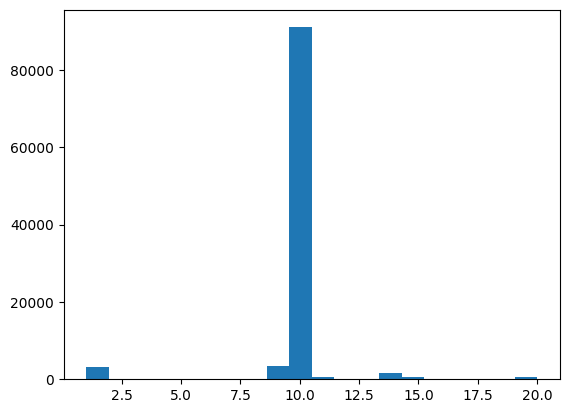

In [86]:
plt.hist(ti_all[(ti_all <= pd.Timedelta('20min'))].astype('timedelta64[s]').astype('int64')/60, bins=20)
plt.show()

In [87]:
# Eliminar registros anteriores a los que tengan time_interval < 9 min
# Son los que están alejados demasiado poco
for id in sensores.keys():
    df_global = sensores[id]['df_global']
    sensores[id]['df_global'] = df_global[(df_global['time_interval'] >= pd.Timedelta('9min')).shift(-1, fill_value=True)]
    sensores[id]['df_global']['time_interval'] = sensores[id]['df_global'].index.diff() # Recalcular
    print(f'Registros en {id}: {len(sensores[id]['df_global'])}')

Registros en 200034001951343334363036: 22808
Registros en 270043001951343334363036: 20126
Registros en 380033001951343334363036: 18966
Registros en 46004e000251353337353037: 5525
Registros en 46005a000351353337353037: 5826
Registros en 4e0022000251353337353037: 2799
Registros en 4e0031000251353337353037: 21773


C:\Users\Alex\AppData\Local\Temp\ipykernel_24372\1539967879.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensores[id]['df_global']['time_interval'] = sensores[id]['df_global'].index.diff() # Recalcular


In [88]:
# Crear un nuevo dataset si time_interval > 36min
for id in list(sensores.keys()):
   df = sensores[id]['df_global']
   splits = df[df['time_interval'] >= pd.Timedelta('60min')]
   # Dividir 
   for i in range(len(splits)):
      new_id = id+f'_v{i+2}'
      if i == len(splits)-1: 
         new_df = df[splits.index[i]:]
      else: 
         new_df = df[splits.index[i]:splits.index[i+1]-pd.Timedelta('1s')]
      # Lo creamos si tiene suficientes registros
      if len(new_df) >= 100:   
         sensores[new_id] = sensores[id].copy()
         new_df.loc[new_df.index.min(), 'time_interval'] = pd.NaT
         sensores[new_id]['df_global'] = new_df
         print(f'Registros en {new_id}:\t {len(sensores[new_id]['df_global'])}')
   sensores[id]['df_global'] = df[:splits.index[0]-pd.Timedelta('1s')]
   # Si el original se ha quedado pequeño, se elimina
   if len(sensores[id]['df_global']) >= 100:
      print(f'Registros en {id}:\t\t {len(sensores[id]['df_global'])}')
   else:
      del sensores[id]

Registros en 200034001951343334363036_v2:	 1248
Registros en 200034001951343334363036_v3:	 16569
Registros en 200034001951343334363036_v4:	 4644
Registros en 200034001951343334363036:		 345
Registros en 270043001951343334363036_v7:	 6573
Registros en 270043001951343334363036_v8:	 6579
Registros en 270043001951343334363036_v9:	 3839
Registros en 270043001951343334363036_v10:	 2711
Registros en 270043001951343334363036_v11:	 338
Registros en 380033001951343334363036_v16:	 12342
Registros en 380033001951343334363036_v17:	 6325
Registros en 380033001951343334363036:		 220
Registros en 46004e000251353337353037_v5:	 606
Registros en 46004e000251353337353037_v6:	 2916
Registros en 46004e000251353337353037_v7:	 589
Registros en 46004e000251353337353037_v9:	 898
Registros en 46004e000251353337353037_v12:	 345
Registros en 46005a000351353337353037_v2:	 5823
Registros en 4e0022000251353337353037_v4:	 206
Registros en 4e0022000251353337353037_v5:	 128
Registros en 4e0022000251353337353037_v11:	 16

In [89]:
times_df = pd.DataFrame(columns=['<8min','>10min','>15min','>20min','>30min','>60min'])

# Loop over the sensors
for id in sensores.keys():
    # Get the time interval for the sensor

    ti = sensores[id]['df_global']['time_interval']
    
    # Add the number of data points in each time interval to the dataframe
    times_df.loc[id] = [
        (len(ti[(ti < pd.Timedelta('8min'))])),
        (len(ti[(ti > pd.Timedelta('10min')) & (ti <= pd.Timedelta('15min'))])),
        (len(ti[(ti > pd.Timedelta('15min')) & (ti <= pd.Timedelta('20min'))])),
        (len(ti[(ti > pd.Timedelta('20min')) & (ti <= pd.Timedelta('30min'))])),
        (len(ti[(ti > pd.Timedelta('30min')) & (ti <= pd.Timedelta('60min'))])),
        (len(ti[(ti > pd.Timedelta('60min'))]))
    ]

times_df

,<8min,>10min,>15min,>20min,>30min,>60min
200034001951343334363036,0,3,0,1,0,0
380033001951343334363036,0,13,10,5,1,0
200034001951343334363036_v2,0,13,2,0,0,0
200034001951343334363036_v3,0,288,10,11,1,0
200034001951343334363036_v4,0,2264,7,54,1,0
270043001951343334363036_v7,0,44,55,12,2,0
270043001951343334363036_v8,0,35,45,3,2,0
270043001951343334363036_v9,0,18,62,12,4,0
270043001951343334363036_v10,0,17,71,32,8,0
270043001951343334363036_v11,0,43,0,0,1,0


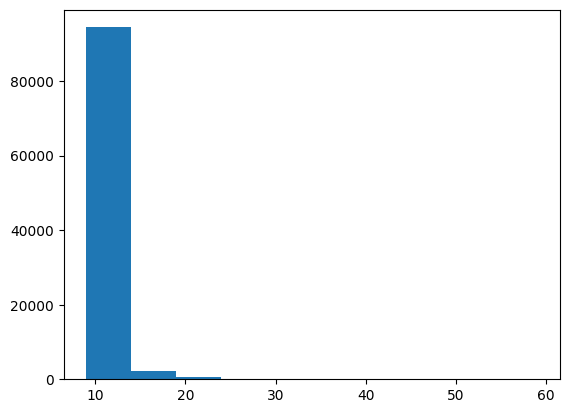

In [90]:
ti_all = pd.Series()
for id in sensores.keys():
    ti = sensores[id]['df_global']['time_interval']
    ti_all = pd.concat([ti_all, ti])
plt.hist(ti_all[(ti_all <= pd.Timedelta('60min'))].astype('timedelta64[s]').astype('int64')/60)
plt.show()

In [91]:
stats_df = pd.DataFrame(columns=['Count', 'NaNs', '%'])

# Loop over the sensors
for id in sensores.keys():
    
    # Add the number of data points in each time interval to the dataframe
    stats_df.loc[id] = [
        len(sensores[id]['df_global']),
        (sensores[id]['df_global'].isnull() != 0).any(axis=1).sum(),
        (sensores[id]['df_global'].isnull() != 0).any(axis=1).sum() / len(sensores[id]['df_global'])*100       
    ]

stats_df

,Count,NaNs,%
200034001951343334363036,345.0,336.0,97.391304
380033001951343334363036,220.0,220.0,100.000000
200034001951343334363036_v2,1248.0,1005.0,80.528846
200034001951343334363036_v3,16569.0,6523.0,39.368701
200034001951343334363036_v4,4644.0,2239.0,48.212748
270043001951343334363036_v7,6573.0,522.0,7.941579
270043001951343334363036_v8,6579.0,900.0,13.679891
270043001951343334363036_v9,3839.0,251.0,6.538161
270043001951343334363036_v10,2711.0,191.0,7.045371
270043001951343334363036_v11,338.0,35.0,10.355030


In [92]:
df_all = pd.DataFrame()
for id in sensores.keys():
    df = sensores[id]['df_global']
    df_all = pd.concat([df_all, df], ignore_index=True)

df_nans = pd.DataFrame(columns=['NaNs', '%'])

for column in df_all.columns:
    df_nans.loc[column] = [(df_all[column].isnull() != 0).sum(),
                           (df_all[column].isnull() != 0).sum()/len(df_all)*100]

df_nans

,NaNs,%
battery,2526.0,2.592657
air_temperature,2725.0,2.796909
atmospheric_pressure,2332.0,2.393538
humidity,2574.0,2.641924
precipitation,2432.0,2.496177
soil_humidity,2349.0,2.410986
wind_direction,18011.0,18.486282
wind_speed,2285.0,2.345298
time_interval,28.0,0.028739


In [93]:
stats_df = pd.DataFrame(columns=['Count', 'NaNs', '%'])

# Loop over the sensors
for id in sensores.keys():
    for column in sensores[id]['df_global'].columns:
        # Add the number of data points in each time interval to the dataframe
        stats_df.loc[f'{id}_{column}'] = [
            len(sensores[id]['df_global'][column]),
            (sensores[id]['df_global'][column].isnull() != 0).sum(),
            (sensores[id]['df_global'][column].isnull() != 0).sum() / len(sensores[id]['df_global'][column])*100       
        ]

stats_df

,Count,NaNs,%
200034001951343334363036_battery,345.0,0.0,0.000000
200034001951343334363036_air_temperature,345.0,0.0,0.000000
200034001951343334363036_atmospheric_pressure,345.0,0.0,0.000000
200034001951343334363036_humidity,345.0,0.0,0.000000
200034001951343334363036_precipitation,345.0,0.0,0.000000
...,...,...,...
4e0031000251353337353037_v6_precipitation,606.0,32.0,5.280528
4e0031000251353337353037_v6_soil_humidity,606.0,15.0,2.475248
4e0031000251353337353037_v6_wind_direction,606.0,106.0,17.491749
4e0031000251353337353037_v6_wind_speed,606.0,26.0,4.290429


In [94]:
df_stats = pd.DataFrame(columns=['Min', 'Mean', 'Median', 'Max', 'Mode', 'STD'])

for column in df_all.columns:
    df_stats.loc[column] = [df_all[column].min(),
                           df_all[column].mean(),
                           df_all[column].median(),
                           df_all[column].max(),
                           df_all[column].mode()[0],
                           df_all[column].std()]
df_stats

,Min,Mean,Median,Max,Mode,STD
battery,0.0,66.768692,69.296875,98.925781,79.933594,15.999797
air_temperature,-46.581871,26.239586,25.201206,46.694302,21.050592,7.983632
atmospheric_pressure,-9.99,990.357734,989.297485,1018.297485,0.0,21.923697
humidity,-5.923706,57.217606,57.446045,118.900818,76.389832,19.448251
precipitation,0.0,0.010685,0.0,16.205196,0.0,0.162256
soil_humidity,0.0,2180.136937,2092.0,4095.0,2.0,1228.903657
wind_direction,0.0,3.364376,3.0,7.0,3.0,2.189148
wind_speed,0.0,3.45216,2.41206,43.417084,0.0,3.947966
time_interval,0 days 00:09:00,0 days 00:10:11.969692302,0 days 00:10:00,0 days 00:59:00,0 days 00:10:00,0 days 00:01:26.623012822


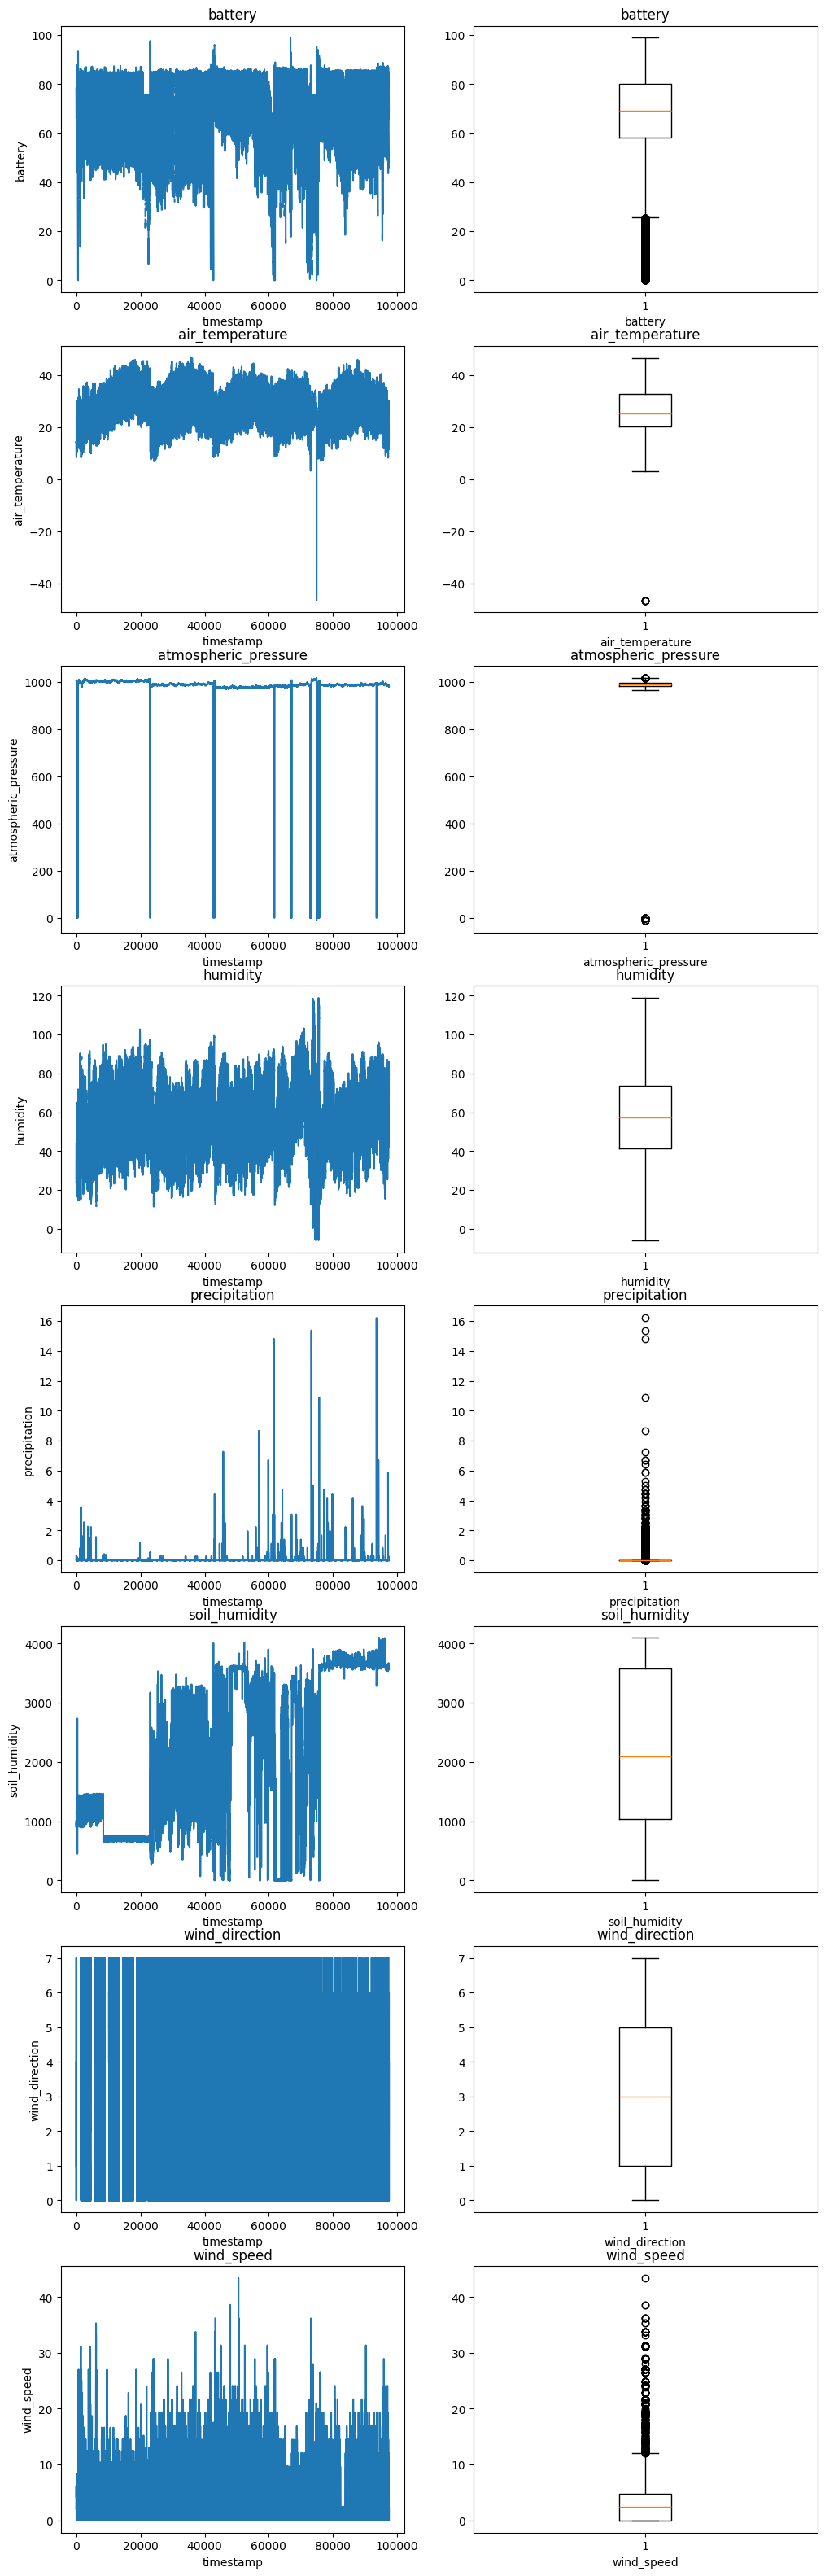

In [95]:
fig, axes = plt.subplots(8, 2, figsize=(12,40))

# Plot the data in each subplot
for i in range(8):
    column = df_all.columns[i]
    axes[i, 0].plot(df_all[column])
    axes[i, 0].set_title(column)
    axes[i, 0].set_xlabel("timestamp")
    axes[i, 0].set_ylabel(column)
    axes[i, 1].boxplot(df_all[column].dropna())
    axes[i, 1].set_title(column)
    axes[i, 1].set_xlabel(column)
plt.show()

Podemos observar como hay varios potenciales valores atípicos en 'battery', 'air_temperature', 'atmospheric_pressure', 'precipitation' y 'wind_speed', aunque la mayoría están dentro del rango de datos posible. Los únicos qu evamos a corregir son los de 'air_temperature' y 'atmospheric_preassure', ya que si queparecen errores claros.

In [96]:
# Corrección de valores atípicos
for id in sensores.keys():
    df = sensores[id]['df_global']
    df['air_temperature'] = df['air_temperature'].where(df['air_temperature'] >= 0, np.nan)
    df['atmospheric_pressure'] = df['atmospheric_pressure'].where(df['atmospheric_pressure'] > 800, np.nan)

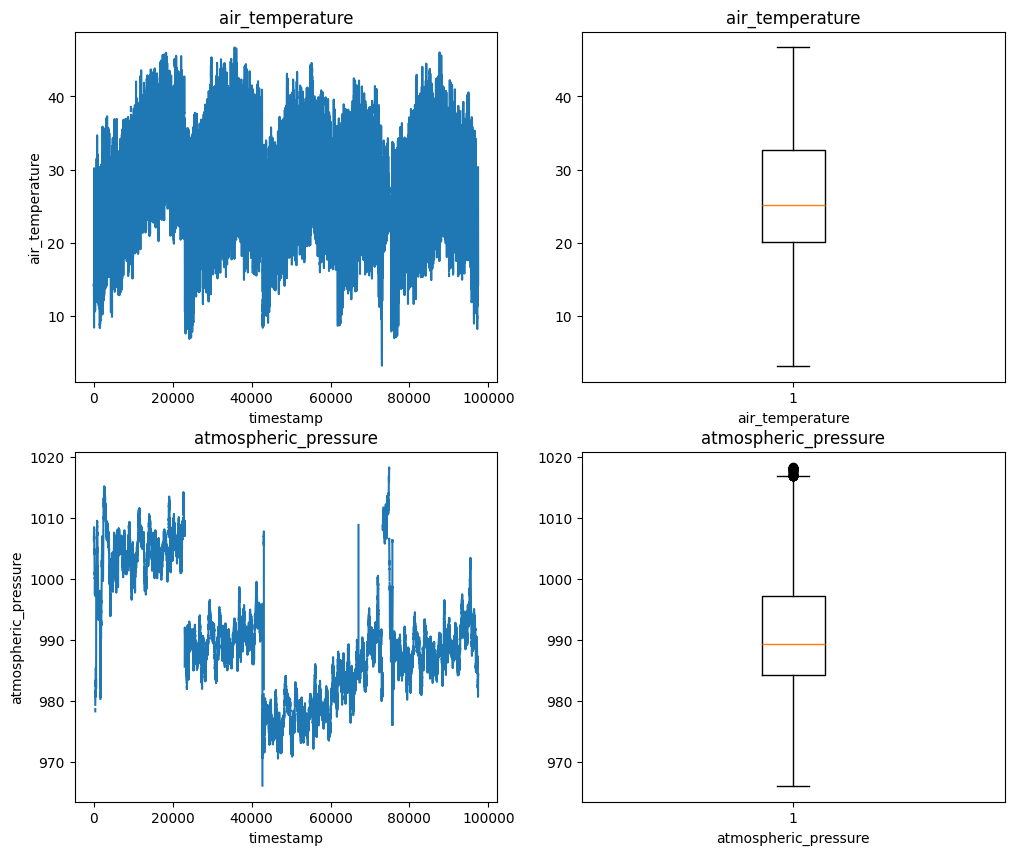

In [97]:
df_all = pd.DataFrame()
for id in sensores.keys():
    df = sensores[id]['df_global']
    df_all = pd.concat([df_all, df], ignore_index=True)

columns = ['air_temperature', 'atmospheric_pressure']

fig, axes = plt.subplots(2, 2, figsize=(12,10))

# Plot the data in each subplot
for i in range(2):
    column = columns[i]
    axes[i, 0].plot(df_all[column])
    axes[i, 0].set_title(column)
    axes[i, 0].set_xlabel("timestamp")
    axes[i, 0].set_ylabel(column)
    axes[i, 1].boxplot(df_all[column].dropna())
    axes[i, 1].set_title(column)
    axes[i, 1].set_xlabel(column)
plt.show()

In [98]:
# Correlaciones
df_all.corr()

,battery,air_temperature,atmospheric_pressure,humidity,precipitation,soil_humidity,wind_direction,wind_speed,time_interval
battery,1.000000,0.480549,-0.083559,-0.540185,-0.011399,0.059197,-0.131107,0.387530,-0.009857
air_temperature,0.480549,1.000000,0.062334,-0.648354,-0.055830,0.053935,-0.137475,0.405928,0.004644
atmospheric_pressure,-0.083559,0.062334,1.000000,0.072591,0.013984,-0.466424,-0.028922,-0.100981,0.002475
humidity,-0.540185,-0.648354,0.072591,1.000000,0.028224,-0.090729,0.091094,-0.486142,0.007123
precipitation,-0.011399,-0.055830,0.013984,0.028224,1.000000,-0.004884,-0.005810,0.035729,0.001110
soil_humidity,0.059197,0.053935,-0.466424,-0.090729,-0.004884,1.000000,-0.090111,0.062554,0.000387
wind_direction,-0.131107,-0.137475,-0.028922,0.091094,-0.005810,-0.090111,1.000000,-0.126893,-0.003883
wind_speed,0.387530,0.405928,-0.100981,-0.486142,0.035729,0.062554,-0.126893,1.000000,0.008832
time_interval,-0.009857,0.004644,0.002475,0.007123,0.001110,0.000387,-0.003883,0.008832,1.000000


Todas > |0.1| excepto air_temperature, precipitation, soil_humidity. Me esperaba que precipitation tuviese una correlación más alta.

In [99]:
# Añadir nuevos registros en registros alejados
limits = ['15min','25min','35min','45min','55min','65min']
for id in sensores.keys():
    df = sensores[id]['df_global']
    # Iteramos sobre cada registro
    for row in df.iterrows():
        for i in range(len(limits)):
            if row[1]['time_interval'] <= pd.Timedelta(limits[i]):
                if(i ==  0):
                    pass # El primer límite no añade registros
                else:
                    new_ti = row[1]['time_interval']/(i+1) # Nuevo time interval
                    # Añadir 'i' nuevos registros
                    for j in range(1, i+1):
                        ts = row[0] - new_ti*j # Nuevo timestamp
                        # Nueva fila
                        data = [None for i in range(len(df.columns)-1)]
                        data.append(new_ti)
                        s = pd.Series(data, index = df.columns, dtype='object')
                        df.loc[ts] = s
                        # Modificar fila actual
                        df.loc[row[0],'time_interval'] = new_ti
                break # No comprobamos los siguientes límites
    df.sort_index(inplace=True) # Reordenamos con los nuevos

In [100]:
# Comprobación de que ningún df tiene intervalos mayores que el mínimo
for id in sensores.keys():
    df = sensores[id]['df_global']
    if (df['time_interval'] > pd.Timedelta(limits[0])).any():
        print(id)

In [101]:
# Interpolar nuevos registros
columnas_linear = ['battery', 'air_temperature', 'atmospheric_pressure', 'humidity', 'precipitation', 'soil_humidity', 'wind_speed']
for id in sensores.keys():
    df = sensores[id]['df_global']
    df[columnas_linear] = df[columnas_linear].interpolate(method='linear', axis=0, limit=999999999999, limit_direction='both')
    if df['wind_direction'].isna().all():
       df[['wind_direction']] = df[['wind_direction']].fillna(-1.0)
    else:
       df[['wind_direction']] = df[['wind_direction']].interpolate(method='nearest', axis=0).ffill().bfill()

In [102]:
for id in sensores.keys():
    df = sensores[id]['df_global']
    if df[columnas_linear].isnull().any().any():
        print(id)

In [103]:
lengths = pd.DataFrame(columns=['id', 'length'])
for id in sensores.keys():
    lengths.loc[len(lengths)] = [id, len(sensores[id]['df_global'])]
lengths = lengths.sort_values(by='length', ascending=False)

In [104]:
len_sum = 0
for row in lengths.iterrows():
    len_sum += row[1]['length']
    print(f'{row[1]['id']}: {row[1]['length']} \tCum. Sum.: {len_sum}')
print('Total:', len_sum, '80%:', round(len_sum*0.8))

200034001951343334363036_v3: 16598 	Cum. Sum.: 16598
380033001951343334363036_v16: 12451 	Cum. Sum.: 29049
4e0031000251353337353037_v2: 11690 	Cum. Sum.: 40739
270043001951343334363036_v7: 6657 	Cum. Sum.: 47396
270043001951343334363036_v8: 6635 	Cum. Sum.: 54031
380033001951343334363036_v17: 6339 	Cum. Sum.: 60370
46005a000351353337353037_v2: 5841 	Cum. Sum.: 66211
4e0031000251353337353037_v4: 5410 	Cum. Sum.: 71621
200034001951343334363036_v4: 4758 	Cum. Sum.: 76379
270043001951343334363036_v9: 3932 	Cum. Sum.: 80311
4e0031000251353337353037_v5: 3278 	Cum. Sum.: 83589
46004e000251353337353037_v6: 2995 	Cum. Sum.: 86584
270043001951343334363036_v10: 2867 	Cum. Sum.: 89451
4e0022000251353337353037_v11: 1625 	Cum. Sum.: 91076
200034001951343334363036_v2: 1250 	Cum. Sum.: 92326
46004e000251353337353037_v9: 905 	Cum. Sum.: 93231
4e0031000251353337353037_v3: 900 	Cum. Sum.: 94131
46004e000251353337353037_v5: 669 	Cum. Sum.: 94800
4e0031000251353337353037_v6: 611 	Cum. Sum.: 95411
46004e000

Nos quedaremos hasta el id '200034001951343334363036_v4' para el entrenamiento y el resto para test.

In [105]:
for column in df_all.columns:
    print(f'{column}: {df_all[column].dtype}')

battery: float64
air_temperature: float64
atmospheric_pressure: float64
humidity: float64
precipitation: float64
soil_humidity: float64
wind_direction: float64
wind_speed: float64
time_interval: timedelta64[ns]


In [106]:
df_all = pd.DataFrame()
for id in sensores.keys():
    df = sensores[id]['df_global']
    df_all = pd.concat([df_all, df], ignore_index=True)

df_stats = pd.DataFrame(columns=['Min', 'Mean', 'Median', 'Max', 'Mode', 'STD'])

for column in df_all.columns:
    df_stats.loc[column] = [df_all[column].min(),
                           df_all[column].mean(),
                           df_all[column].median(),
                           df_all[column].max(),
                           df_all[column].mode()[0],
                           df_all[column].std()]
df_stats

,Min,Mean,Median,Max,Mode,STD
battery,0.0,66.665314,69.296875,98.925781,79.933594,16.056644
air_temperature,3.214756,26.21744,25.160094,46.694302,21.050592,7.963821
atmospheric_pressure,966.10498,990.752667,989.278778,1018.297485,987.575012,9.888978
humidity,-5.923706,57.243569,57.457489,118.900818,76.389832,19.395732
precipitation,0.0,0.010785,0.0,16.205196,0.0,0.161188
soil_humidity,0.0,2172.991381,2079.416667,4095.0,2.0,1228.893107
wind_direction,-1.0,3.306824,3.0,7.0,3.0,2.260022
wind_speed,0.0,3.447749,2.41206,43.417084,0.0,3.947567
time_interval,0 days 00:08:00,0 days 00:10:05.658226304,0 days 00:10:00,0 days 00:15:00,0 days 00:10:00,0 days 00:00:39.719324683


In [107]:
wd_columns = ['wd_0.0', 'wd_1.0', 'wd_2.0', 'wd_3.0', 'wd_4.0', 'wd_5.0', 'wd_6.0', 'wd_7.0', 'wd_-1.0']

# Normalizar datos
for id in sensores.keys():
    df = sensores[id]['df_global']
    df.drop('time_interval', axis=1, inplace=True)
    for column in df.columns:
        if column == 'wind_direction':
            dummies = pd.get_dummies(df['wind_direction'], prefix='wd')
            # Añadir columnas si no estan despues del dummies
            for wd_col in wd_columns:
                if wd_col not in dummies.columns:
                    dummies[wd_col] = [False for i in range(len(dummies))]
            dummies = dummies.reindex(sorted(dummies.columns), axis=1)
            df = pd.concat([df, dummies], axis=1)
            df.drop('wind_direction', axis=1, inplace=True)
        else:
            df_min = df_stats.loc[column, 'Min']
            df_max = df_stats.loc[column, 'Max']
            df[column] = (df[column] - df_min) / (df_max - df_min)
    sensores[id]['df_global'] = df

In [108]:
sensores[id]['df_global']

,battery,air_temperature,atmospheric_pressure,humidity,precipitation,soil_humidity,wind_speed,wd_-1.0,wd_0.0,wd_1.0,wd_2.0,wd_3.0,wd_4.0,wd_5.0,wd_6.0,wd_7.0
timestamp,,,,,,,,,,,,,,,,
2018-10-06 18:16:00,0.821204,0.592995,0.379604,0.486523,0.0,0.888156,0.055556,False,False,False,True,False,False,False,False,False
2018-10-06 18:26:00,0.826140,0.575728,0.371941,0.504126,0.0,0.890842,0.111111,False,False,False,True,False,False,False,False,False
2018-10-06 18:36:00,0.826140,0.560064,0.370696,0.518153,0.0,0.883272,0.194444,False,False,False,True,False,False,False,False,False
2018-10-06 18:46:00,0.822823,0.544401,0.369450,0.532180,0.0,0.886447,0.277778,False,False,False,False,True,False,False,False,False
2018-10-06 18:56:00,0.812952,0.534534,0.371797,0.539943,0.0,0.888400,0.277778,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-10 23:15:00,0.705469,0.265417,0.343776,0.675692,0.0,0.871062,0.000000,False,False,False,False,True,False,False,False,False
2018-10-10 23:25:00,0.703810,0.264677,0.348135,0.683760,0.0,0.870574,0.000000,False,False,False,False,False,True,False,False,False
2018-10-10 23:35:00,0.700494,0.259743,0.351776,0.683149,0.0,0.870818,0.000000,False,True,False,False,False,False,False,False,False


In [109]:
train_dfs_ids = ['200034001951343334363036_v3', '380033001951343334363036_v16',
       '4e0031000251353337353037_v2', '270043001951343334363036_v7',
       '270043001951343334363036_v8', '380033001951343334363036_v17',
       '46005a000351353337353037_v2', '4e0031000251353337353037_v4',
       '200034001951343334363036_v4']
test_dfs_ids = ['270043001951343334363036_v9',
       '4e0031000251353337353037_v5', '46004e000251353337353037_v6',
       '270043001951343334363036_v10', '4e0022000251353337353037_v11',
       '200034001951343334363036_v2', '46004e000251353337353037_v9',
       '4e0031000251353337353037_v3', '46004e000251353337353037_v5',
       '4e0031000251353337353037_v6', '46004e000251353337353037_v7',
       '4e0022000251353337353037_v13', '4e0022000251353337353037_v14',
       '46004e000251353337353037_v12', '200034001951343334363036',
       '270043001951343334363036_v11', '380033001951343334363036',
       '4e0022000251353337353037_v4', '4e0022000251353337353037_v5']
train_dfs = [sensores[id]['df_global'].to_numpy() for id in sensores.keys() if id in train_dfs_ids]
test_dfs = [sensores[id]['df_global'].to_numpy() for id in sensores.keys() if id in test_dfs_ids]

In [110]:
dfs = [sensores[id]['df_global'].to_numpy() for id in sensores.keys()]

In [111]:
test_dfs[1]

array([[0.783257652522349, 0.4166255323825138, 0.2243141999028409, ...,
        False, False, False],
       [0.8261401848321015, 0.4033670280273856, 0.2243141999028409, ...,
        False, False, False],
       [0.8343928970345961, 0.3901085236722573, 0.2289123696975276, ...,
        False, False, False],
       ...,
       [0.0008292176131518223, 0.3741983414454235, 0.3092400910820439,
        ..., False, False, False],
       [0.00041460880657591116, 0.36988159903969553, 0.30727604471178444,
        ..., False, False, False],
       [0.0, 0.3655648566339676, 0.305311998341525, ..., False, False,
        False]], dtype=object)

In [112]:
# Guardar datos
import pickle

# Guardar datos en un archivo
with open('pickles/sensores_clean.pkl', 'wb') as archivo:
    pickle.dump(sensores, archivo)
with open('pickles/train_dfs.pkl', 'wb') as archivo:
    pickle.dump(train_dfs, archivo)
with open('pickles/test_dfs.pkl', 'wb') as archivo:
    pickle.dump(test_dfs, archivo)
with open('pickles/dfs.pkl', 'wb') as archivo:
    pickle.dump(dfs, archivo)